In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load all datasets
file_deaths_population = "../data/processed/States_Deaths_Populations.csv"
file_poverty = "../data/processed/US_Poverty_Rate.csv"
file_income_per_capita = "../data/processed/Personal_Income_Per_Capita.csv"
file_health_care = "../data/processed/Personal_Health_Care_Per_Capita.csv"
file_median_income = "../data/processed/Median_Household_Income.csv"

# Read CSV files
df_deaths_population = pd.read_csv(file_deaths_population)
df_poverty = pd.read_csv(file_poverty)
df_income_per_capita = pd.read_csv(file_income_per_capita)
df_health_care = pd.read_csv(file_health_care)
df_median_income = pd.read_csv(file_median_income)

# Reshape "Income Per Capita" dataset to long format
df_income_per_capita_long = df_income_per_capita.melt(id_vars=["State"], var_name="Year", value_name="Income Per Capita")

# Convert "Year" to integer for consistency
df_income_per_capita_long["Year"] = df_income_per_capita_long["Year"].astype(int)

# Try merging all datasets
df_master = df_deaths_population.merge(df_poverty, on=["State", "Year"], how="left")
df_master = df_master.merge(df_income_per_capita_long, on=["State", "Year"], how="left")
df_master = df_master.merge(df_health_care, on=["State", "Year"], how="left")
df_master = df_master.merge(df_median_income, on=["State", "Year"], how="left")

# Recalculate Proportional Death Rate (deaths per 100,000 population)
df_master["Proportional Death Rate"] = (df_master["Deaths"] / df_master["Population"]) * 100000

print(df_master.head())

   Year       State  Deaths  Population  Poverty Rate  Income Per Capita  \
0  1999     Alabama   80246     4430141          15.2              23296   
1  1999      Alaska    4782      624779           7.6              29941   
2  1999     Arizona   71846     5023823          12.2              24866   
3  1999    Arkansas   49937     2651860          14.7              21842   
4  1999  California  415533    33499204          14.0              30529   

   Spending  Median Income  Proportional Death Rate  
0    3689.0        36251.0              1811.364469  
1    4076.0        51396.0               765.390642  
2    3068.0        36995.0              1430.106116  
3    3517.0        29682.0              1883.093376  
4    3436.0        43629.0              1240.426489  


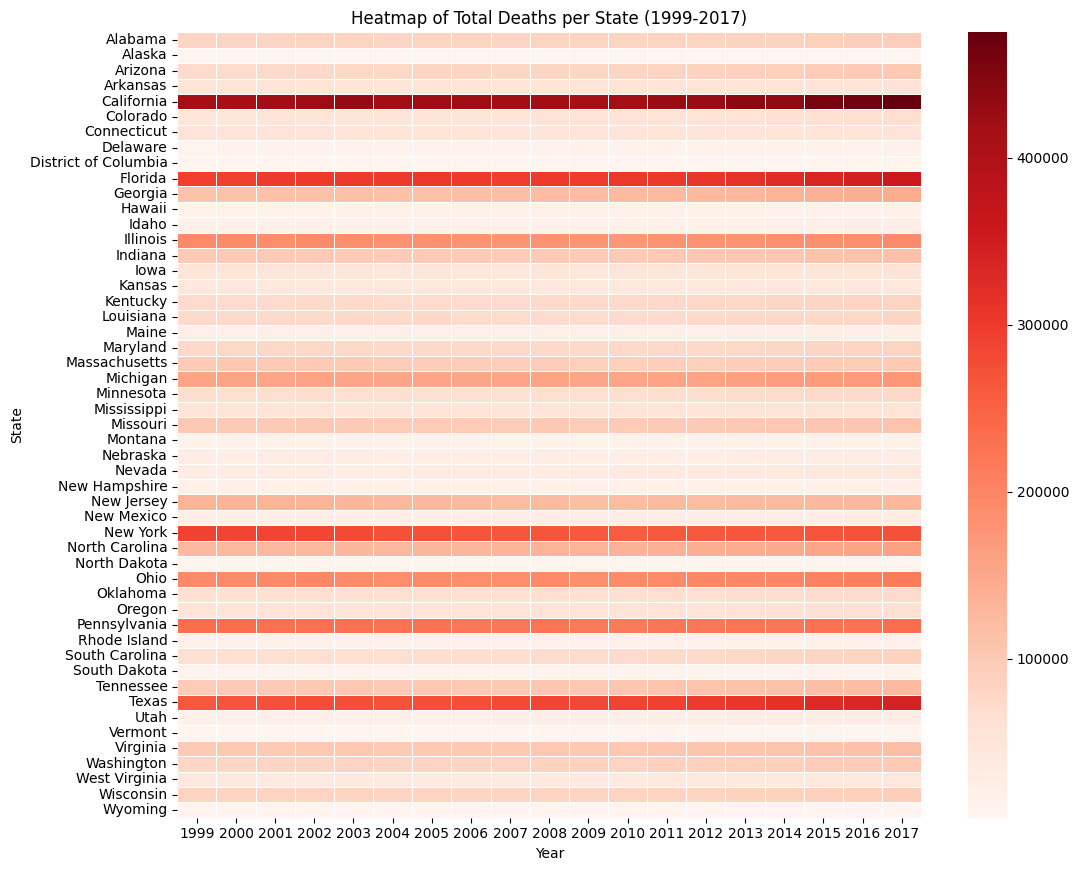

In [85]:
# Step 1: Create a heatmap for total deaths per state over time
heatmap_data_deaths = df_master.pivot(index="State", columns="Year", values="Deaths")

plt.figure(figsize=(12, len(heatmap_data_deaths) * 0.2))
sns.heatmap(heatmap_data_deaths, cmap="Reds", annot=False, linewidths=0.5)
plt.title("Heatmap of Total Deaths per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()


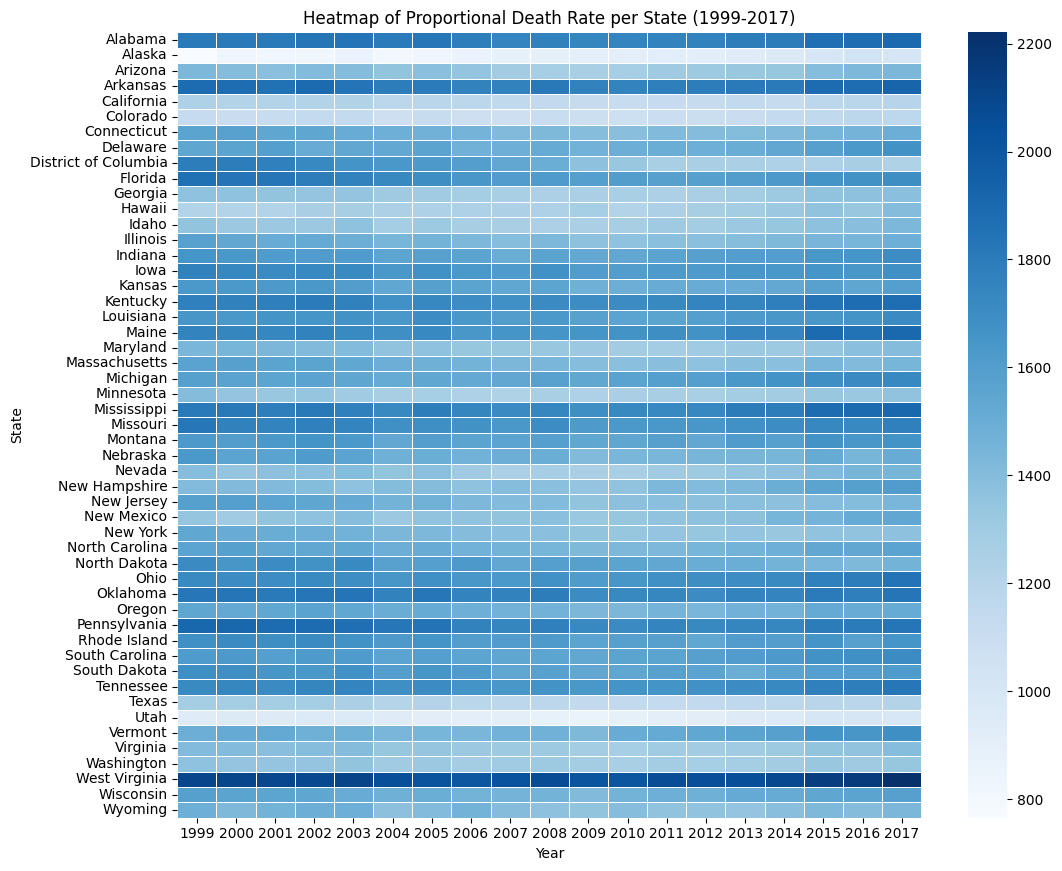

In [86]:
# Step 2: # Recalculate Proportional Death Rate (deaths per 100,000 population)
heatmap_data_proportional = df_master.pivot(index="State", columns="Year", values="Proportional Death Rate")

plt.figure(figsize=(12, len(heatmap_data_proportional) * 0.2))
sns.heatmap(heatmap_data_proportional, cmap="Blues", annot=False, linewidths=0.5)
plt.title("Heatmap of Proportional Death Rate per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()

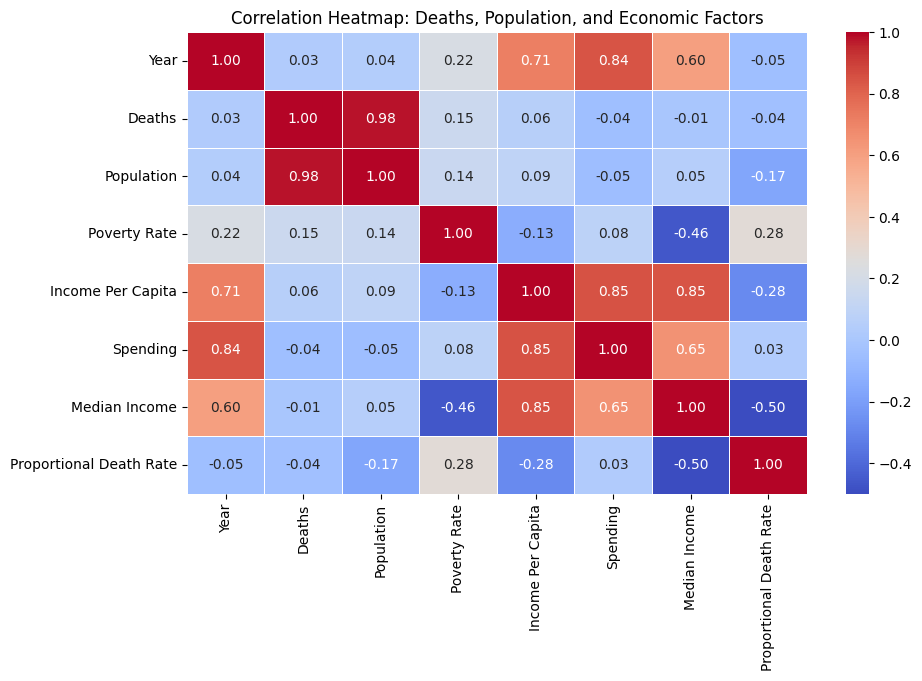

In [89]:
# Compute correlation matrix between deaths, population
numeric_df = df_master.select_dtypes(include=["number"])

# Compute correlation matrix for deaths, population, and economic factors
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Deaths, Population, and Economic Factors")
plt.show()

1. Deaths vs. Population → Strong positive correlation
This is expected because larger states have more total deaths.
2️. Proportional Death Rate vs. Population → Weak negative correlation
Suggests that larger states tend to have lower deaths per capita.
3️. Poverty Rate vs. Proportional Death Rate → Positive correlation
Higher poverty rates may be linked to higher death rates.
4️. Income Per Capita vs. Proportional Death Rate → Negative correlation
Suggests that wealthier states may have lower death rates.
5️. Healthcare Spending vs. Death Rates → Needs further investigation
The correlation may indicate whether higher spending actually reduces mortality.

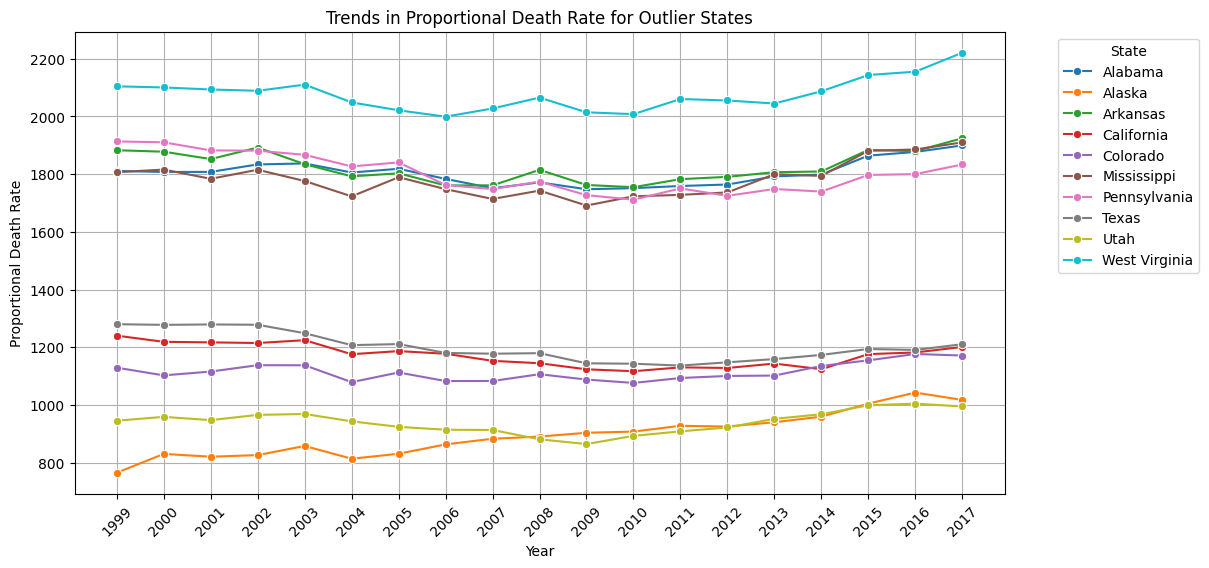

In [91]:
# Identify states with the highest and lowest proportional death rates over time
avg_death_rate_by_state = df_master.groupby("State")["Proportional Death Rate"].mean()

# Get the top 5 and bottom 5 states
top_outlier_states = avg_death_rate_by_state.nlargest(5).index
bottom_outlier_states = avg_death_rate_by_state.nsmallest(5).index

# Filter the dataset for these outlier states
df_outliers = df_master[df_master["State"].isin(top_outlier_states.union(bottom_outlier_states))]

# Plot trends for these outlier states
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_outliers, x="Year", y="Proportional Death Rate", hue="State", marker="o")
# Ensure x-axis shows full years
plt.xticks(ticks=df_outliers["Year"].unique(), rotation=45)

plt.xlabel("Year")
plt.ylabel("Proportional Death Rate")
plt.title("Trends in Proportional Death Rate for Outlier States")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

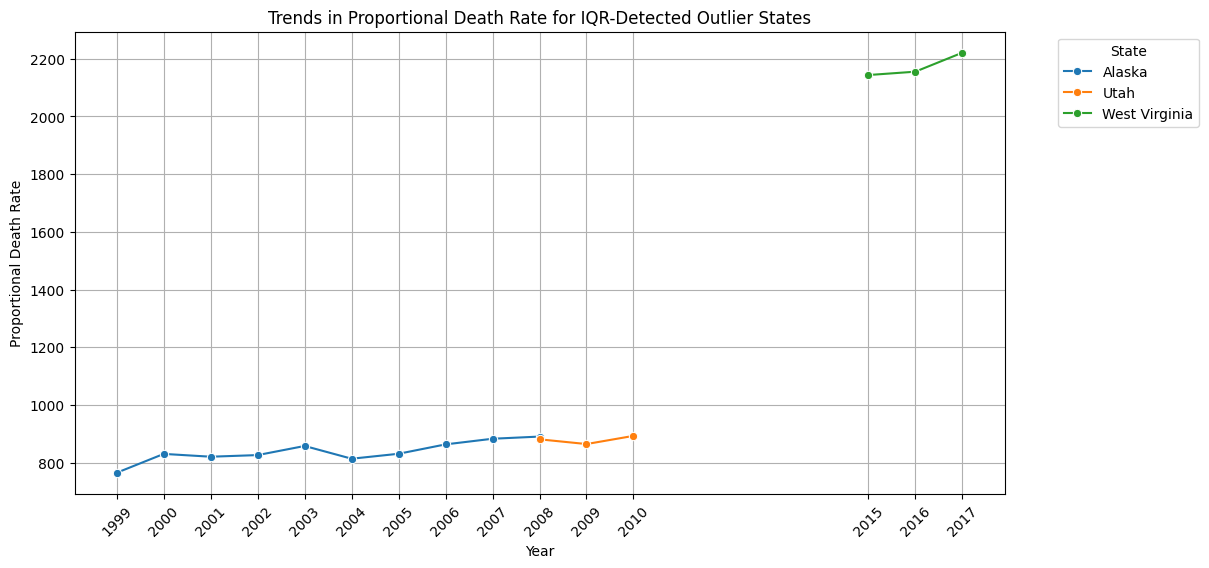

In [92]:
# Compute the IQR for proportional death rates
Q1 = df_master["Proportional Death Rate"].quantile(0.25)  # 25th percentile
Q3 = df_master["Proportional Death Rate"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile Range

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify statistical outliers based on IQR method
df_outliers_iqr = df_master[(df_master["Proportional Death Rate"] < lower_bound) | 
                            (df_master["Proportional Death Rate"] > upper_bound)]

# Plot trends for these IQR-based outlier states
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_outliers_iqr, x="Year", y="Proportional Death Rate", hue="State", marker="o")

# Ensure x-axis shows full years
plt.xticks(ticks=df_outliers_iqr["Year"].unique(), rotation=45)

plt.xlabel("Year")
plt.ylabel("Proportional Death Rate")
plt.title("Trends in Proportional Death Rate for IQR-Detected Outlier States")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()